In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy.optimize import brentq

In [2]:
# data = pd.read_csv('F:\workspace\ipython\ECON3334\caschool.csv')
df = pd.read_csv("https://raw.githubusercontent.com/gerald-liu/ipython/master/ECON3334/caschool.csv",
                 usecols=['testscr', 'str', 'el_pct', 'meal_pct', 'avginc'])

In [3]:
df['str_X_elpct'] = df['str'].mul(df['el_pct'])
df['loginc'] = df['avginc'].apply(np.log)
df = df[['testscr', 'str', 'el_pct', 'str_X_elpct', 'meal_pct', 'loginc']]

In [5]:
lm = smf.ols(formula='testscr ~ ' + ' + '.join(df.columns.tolist()[1:6]), data=df).fit(cov_type='HC1')
lm_table = pd.DataFrame({'Coef':lm.params, 'SE':lm.bse, 't-stat':lm.tvalues})
lm_table['p-value'] = lm.pvalues
lm_table = pd.concat([lm_table, lm.conf_int().rename(columns={0: '95%CI_LB', 1: '95%CI_UB'})], axis=1)
lm_table

,Coef,SE,t-stat,p-value,95%CI_LB,95%CI_UB
Intercept,663.157651,10.054347,65.957309,0.000000e+00,643.451494,682.863809
str,-0.946666,0.346875,-2.729130,6.350175e-03,-1.626528,-0.266804
el_pct,-0.481824,0.246129,-1.957606,5.027628e-02,-0.964228,0.000580
str_X_elpct,0.015480,0.012334,1.255095,2.094442e-01,-0.008694,0.039655
meal_pct,-0.401380,0.033270,-12.064393,1.628578e-33,-0.466587,-0.336172
loginc,11.433074,1.817734,6.289740,3.179988e-10,7.870380,14.995767


$$
\begin{aligned}
\Delta testscr &= (\beta_1+\beta_3\cdot el\_pct)\sigma_{str} \\
&= \beta_1\sigma_{str}+\beta_3\sigma_{str}\cdot el\_pct \\
\ \\
SE(\Delta testscr) &= \sqrt{var(\beta_1)\sigma_{str}^2+var(\beta_3)\sigma_{str}^2(el\_pct)^2+2\beta_1\beta_3\sigma_{str}^2\cdot el\_pct\cdot cov(\beta_1, \beta_3)}
\end{aligned}
$$

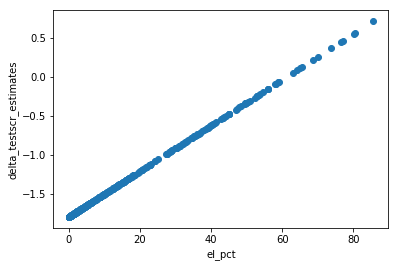

In [6]:
plt.scatter(df['el_pct'], df['el_pct'].apply(lambda x: (lm.params[1] + lm.params[3]*x) * df['str'].std()))
plt.xlabel('el_pct')
plt.ylabel('delta_testscr_estimates')
plt.savefig('hw5_2.png')

$$
\begin{aligned}
H_0: \Delta testscr &= \beta_1\sigma_{str}+\beta_3\sigma_{str}\cdot el\_pct = 0 \\
H_1: \Delta testscr &\neq 0
\end{aligned}
$$

In [7]:
def se_dy_simple_linear(x, b, k, var_b, var_k, cov_bk): # y = b + kx
    return math.sqrt(var_b + var_k * x**2 + 2*b*k*x*cov_bk)

f = lm.f_test('str + str_X_elpct = 0').fvalue[0][0]
b = lm.params[1] * df['str'].std()
k = lm.params[3] * df['str'].std()
var_b = lm.bse[1]**2 * df['str'].var()
var_k = lm.bse[3]**2 * df['str'].var()
cov_bk = ((lm.params[1]+lm.params[3])**2 /f - lm.bse[1]**2 - lm.bse[3]**2)/2

In [8]:
el_pct_test = pd.Series(np.arange(1, 81))
df_1 = pd.DataFrame({'se_dy': el_pct_test.apply(se_dy_simple_linear, args=(b, k, var_b, var_k, cov_bk,)),
                     'el_pct': el_pct_test})
df_1['t-stat'] = (b + k*df_1['el_pct'])/df_1['se_dy']
df_1['95%CI_LB'] = df_1['t-stat'] + norm.ppf(0.05/2)*df_1['se_dy']
df_1['95%CI_UB'] = df_1['t-stat'] - norm.ppf(0.05/2)*df_1['se_dy']

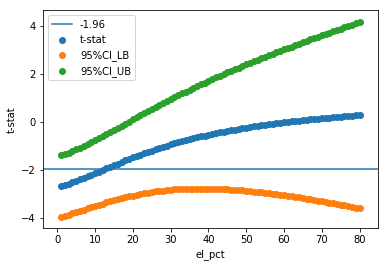

In [9]:
plt.scatter(df_1['el_pct'], df_1['t-stat'])
plt.scatter(df_1['el_pct'], df_1['95%CI_LB'])
plt.scatter(df_1['el_pct'], df_1['95%CI_UB'])
plt.axhline(y=norm.ppf(0.05/2), label='-1.96')
plt.xlabel('el_pct')
plt.ylabel('t-stat')
plt.legend()
plt.savefig('hw5_4.png')

In [10]:
def t_dy_simple_linear(x):
    return (b + k*x)/se_dy_simple_linear(x, b, k, var_b, var_k, cov_bk)

def solver(x):
    return t_dy_simple_linear(x) - norm.ppf(0.05/2)

print("For el_pct < {:.4f}, the change in testscr is significant at 5% level.".format(brentq(solver, 10, 20)))

For el_pct < 12.7497, the change in testscr is significant at 5% level.
